In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    Cont = np.array([])
    SBJ = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta0 = prms['delta0'].values[i]
        delta1 = prms['delta1'].values[i]
        t0 = prms['t0'].values[i]
        
        if model == 'exp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 * np.exp(-lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'hyp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 / (1 + lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'ddm':
            b0 = prms['b0'].values[i]
            ub = lambda t: b0
            lb = lambda t: -1*ub(t)   

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)
        contrast = sbj_data.contrast.values

        rt = []

        for c in contrast:
            delta = delta0 - delta1*np.log(c)
#             delta = delta0 - delta1*np.log((c/100 - 0.025)/(c/100 + 0.025))
            rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))

        RT = np.concatenate([RT, rt])
        Cont = np.concatenate([Cont, contrast])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'rt': np.abs(RT),
                         'accuracy': RT>0,
                         'contrast': Cont,
                         'g_contrast': Cont//10*10}) 

In [4]:
data = pd.read_csv('../../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data.event == 3]
data['rt']/=1000
data['Duration']/=1000

data['g_contrast'] = data['contrast']//10*10

data_speed = data[data.condition == 'speed'].reset_index(drop=True)
data_accuracy = data[data.condition == 'accuracy'].reset_index(drop=True)

In [5]:
data['g_contrast'].nunique()

10

In [6]:
hyp_speed = pd.read_csv('_prms/hyp_speed.csv')
hyp_accuracy = pd.read_csv('_prms/hyp_accuracy.csv')
exp_speed = pd.read_csv('_prms/exp_speed.csv')
exp_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
jddm_speed = pd.read_csv('_prms/jddm_speed.csv')
jddm_accuracy = pd.read_csv('_prms/jddm_accuracy.csv')

bhyp_speed = pd.read_csv('_prms/bhyp_speed.csv')
bhyp_accuracy = pd.read_csv('_prms/bhyp_accuracy.csv')
bexp_speed = pd.read_csv('_prms/bexp_speed.csv')
bexp_accuracy = pd.read_csv('_prms/bexp_accuracy.csv')
bddm_speed = pd.read_csv('_prms/bddm_speed.csv')
bddm_accuracy = pd.read_csv('_prms/bddm_accuracy.csv')

In [7]:
pred_hyp_sp = get_model_prediction(hyp_speed, data_speed, 'hyp')
pred_hyp_ac = get_model_prediction(hyp_accuracy, data_accuracy, 'hyp')

100%|███████████████████████████████████████████████| 26/26 [00:13<00:00,  1.94it/s]


In [8]:
pred_bhyp_sp = get_model_prediction(bhyp_speed, data_speed, 'hyp')
pred_bhyp_ac = get_model_prediction(bhyp_accuracy, data_accuracy, 'hyp')

100%|███████████████████████████████████████████████| 26/26 [00:12<00:00,  2.14it/s]


In [9]:
pred_exp_sp = get_model_prediction(exp_speed, data_speed, 'exp')
pred_exp_ac = get_model_prediction(exp_accuracy, data_accuracy, 'exp')

100%|███████████████████████████████████████████████| 26/26 [00:20<00:00,  1.25it/s]


In [10]:
pred_bexp_sp = get_model_prediction(bexp_speed, data_speed, 'exp')
pred_bexp_ac = get_model_prediction(bexp_accuracy, data_accuracy, 'exp')

100%|███████████████████████████████████████████████| 26/26 [00:17<00:00,  1.48it/s]


In [11]:
pred_jddm_sp = get_model_prediction(jddm_speed, data_speed, 'ddm')
pred_jddm_ac = get_model_prediction(jddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████████| 26/26 [00:11<00:00,  2.17it/s]


In [12]:
pred_bddm_sp = get_model_prediction(bddm_speed, data_speed, 'ddm')
pred_bddm_ac = get_model_prediction(bddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████████| 26/26 [00:09<00:00,  2.67it/s]


In [13]:
def plot_model_pred(pred, var, color, x, style, label):
    err = scipy.stats.t.ppf(0.975, 26)
    temp = pred.groupby(by=['sbj', 'g_contrast'])[var].mean()
    temp = pd.DataFrame(np.array([temp[i].values for i in pred.sbj.unique()]), 
                        columns=[j*10 for j in range(10)])
    plt.errorbar(x= x + pred.groupby(by='g_contrast')['g_contrast'].mean(), 
                 y= pred.groupby(by='g_contrast')[var].mean(),
                 linestyle=style,
                 yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]),
                 label=label,
                 c=color);
#     plt.scatter(x=x + pred.groupby(by='g_contrast')['g_contrast'].mean(), 
#                 y=pred.groupby(by='g_contrast')[var].mean(),
#                 color=color)

In [14]:
def plot_rt_quantiles(pred, var, color, x, label):
    err = scipy.stats.t.ppf(0.975, 26)
    for q in [0.1, 0.3, 0.5, 0.7, 0.9]:
        quantiles = pred.groupby(by=['sbj'])[var].quantile(q)
        plt.errorbar(x= 10*q + x, 
                     y= quantiles.mean(),
                     yerr=err*quantiles.std()/np.sqrt(26), 
                     label=label, c=color);
        plt.scatter(x=10*q + x, y=quantiles.mean(), color=color)

In [15]:
c_data = '#2A628F'
c_jhyp = '#C8D5B9'
c_jexp = '#8FC0A9'
c_jddm = '#C0D7BB'
c_bhyp = '#7D82B8'
c_bexp = '#628395'
c_bddm = '#4BA3C3'

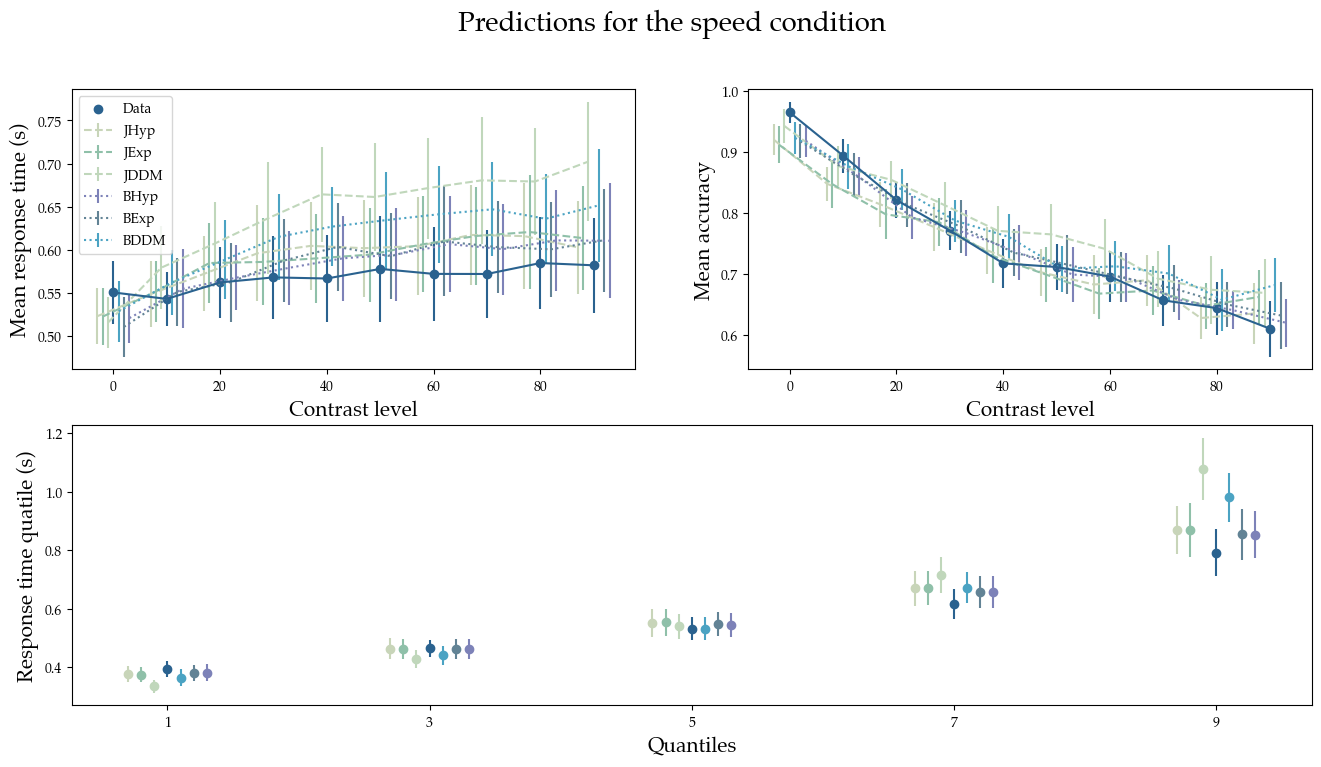

In [17]:
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Predictions for the speed condition', fontsize=20)

gs = GridSpec(2, 2, figure=fig)

fig.add_subplot(gs[0, 0])
plot_model_pred(pred_hyp_sp, 'rt', c_jhyp, -3, '--', 'JHyp')
plot_model_pred(pred_exp_sp, 'rt', c_jexp, -2, '--', 'JExp')
plot_model_pred(pred_jddm_sp, 'rt', c_jddm, -1, '--', 'JDDM')
plot_model_pred(pred_bhyp_sp, 'rt', c_bhyp, 3, ':', 'BHyp')
plot_model_pred(pred_bexp_sp, 'rt', c_bexp, 2, ':', 'BExp')
plot_model_pred(pred_bddm_sp, 'rt', c_bddm, 1, ':', 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
temp = data_speed.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c=c_data);
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
            c=c_data, label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend(loc='upper left');

fig.add_subplot(gs[0, 1])
plot_model_pred(pred_hyp_sp, 'accuracy', c_jhyp, -3, '--', 'JHyp')
plot_model_pred(pred_exp_sp, 'accuracy', c_jexp, -2, '--', 'JExp')
plot_model_pred(pred_jddm_sp, 'accuracy', c_jddm, -1, '--', 'JDDM')
plot_model_pred(pred_bhyp_sp, 'accuracy', c_bhyp, 3, ':', 'BHyp')
plot_model_pred(pred_bexp_sp, 'accuracy', c_bexp, 2, ':', 'BExp')
plot_model_pred(pred_bddm_sp, 'accuracy', c_bddm, 1, ':', 'BDDM')

temp = data_speed.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c=c_data);
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
            c=c_data, label='Data');

plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15);

fig.add_subplot(gs[1, :])
plot_rt_quantiles(pred_hyp_sp, 'rt', c_jhyp, -0.3, 'JHyp')
plot_rt_quantiles(pred_exp_sp, 'rt', c_jexp, -.2, 'JExp')
plot_rt_quantiles(pred_jddm_sp, 'rt', c_jddm, -.1, 'JDDM')
plot_rt_quantiles(pred_bhyp_sp, 'rt', c_bhyp, .3, 'BHyp')
plot_rt_quantiles(pred_bexp_sp, 'rt', c_bexp, .2, 'BExp')
plot_rt_quantiles(pred_bddm_sp, 'rt', c_bddm, .1, 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
for q in [0.1, 0.3, 0.5, 0.7, 0.9]:
    quantiles = data_speed.groupby(by=['participant'])['rt'].quantile(q)
    plt.errorbar(x= 10*q, 
                 y= quantiles.mean(),
                 yerr=err*quantiles.std()/np.sqrt(26), 
                 label='Data', c=c_data);
    plt.scatter(x=10*q, y=quantiles.mean(), color=c_data)
plt.xticks([1, 3, 5, 7, 9], [1, 3, 5, 7, 9]);
plt.ylabel('Response time quatile (s)', fontsize=15);
plt.xlabel('Quantiles', fontsize=15);

plt.savefig('_plots/S1_speed_pred.pdf', 
            transparent=True, 
            dpi=400, 
            bbox_inches='tight');

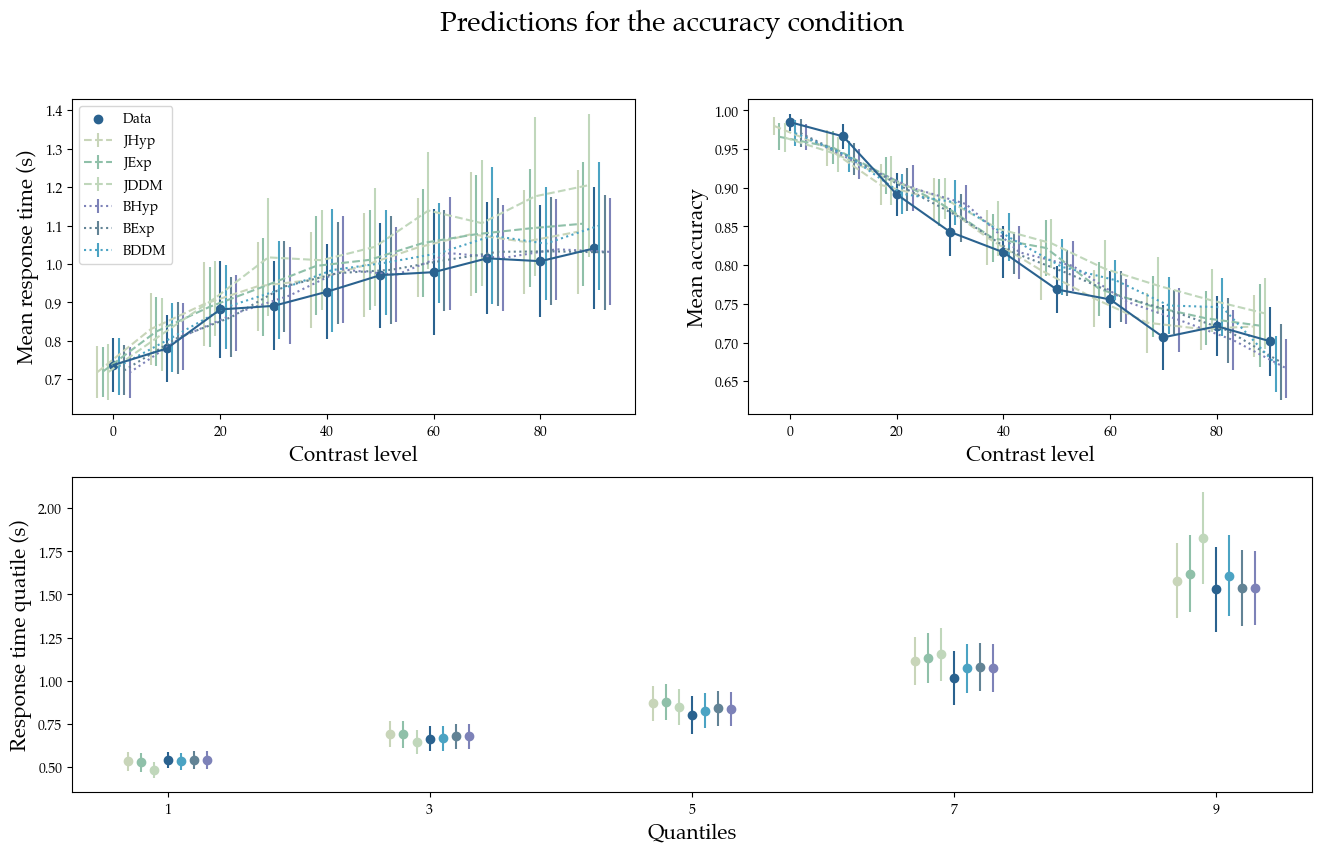

In [19]:
fig = plt.figure(figsize=(16, 9))
fig.suptitle('Predictions for the accuracy condition', fontsize=20)

gs = GridSpec(2, 2, figure=fig)

fig.add_subplot(gs[0, 0])
plot_model_pred(pred_hyp_ac, 'rt', c_jhyp, -3, '--', 'JHyp')
plot_model_pred(pred_exp_ac, 'rt', c_jexp, -2, '--', 'JExp')
plot_model_pred(pred_jddm_ac, 'rt', c_jddm, -1, '--', 'JDDM')
plot_model_pred(pred_bhyp_ac, 'rt', c_bhyp, 3, ':', 'BHyp')
plot_model_pred(pred_bexp_ac, 'rt', c_bexp, 2, ':', 'BExp')
plot_model_pred(pred_bddm_ac, 'rt', c_bddm, 1, ':', 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c=c_data);
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
            c=c_data, label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend(loc='upper left');

fig.add_subplot(gs[0, 1])
plot_model_pred(pred_hyp_ac, 'accuracy', c_jhyp, -3, '--', 'JHyp')
plot_model_pred(pred_exp_ac, 'accuracy', c_jexp, -2, '--', 'JExp')
plot_model_pred(pred_jddm_ac, 'accuracy', c_jddm, -1, '--', 'JDDM')
plot_model_pred(pred_bhyp_ac, 'accuracy', c_bhyp, 3, ':', 'BHyp')
plot_model_pred(pred_bexp_ac, 'accuracy', c_bexp, 2, ':', 'BExp')
plot_model_pred(pred_bddm_ac, 'accuracy', c_bddm, 1, ':', 'BDDM')

temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c=c_data);
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
            c=c_data, label='Data');

plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15);


fig.add_subplot(gs[1, :])
plot_rt_quantiles(pred_hyp_ac, 'rt', c_jhyp, -0.3, 'JHyp')
plot_rt_quantiles(pred_exp_ac, 'rt', c_jexp, -.2, 'JExp')
plot_rt_quantiles(pred_jddm_ac, 'rt', c_jddm, -.1, 'JDDM')
plot_rt_quantiles(pred_bhyp_ac, 'rt', c_bhyp, .3, 'BHyp')
plot_rt_quantiles(pred_bexp_ac, 'rt', c_bexp, .2, 'BExp')
plot_rt_quantiles(pred_bddm_ac, 'rt', c_bddm, .1, 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
for q in [0.1, 0.3, 0.5, 0.7, 0.9]:
    quantiles = data_accuracy.groupby(by=['participant'])['rt'].quantile(q)
    plt.errorbar(x= 10*q, 
                 y= quantiles.mean(),
                 yerr=err*quantiles.std()/np.sqrt(26), 
                 label='Data', c=c_data);
    plt.scatter(x=10*q, y=quantiles.mean(), color=c_data)
plt.ylabel('Response time quatile (s)', fontsize=15);
plt.xticks([1, 3, 5, 7, 9], [1, 3, 5, 7, 9]);
plt.xlabel('Quantiles', fontsize=15);

plt.savefig('_plots/S1_accuracy_pred.pdf', 
            transparent=True, 
            dpi=400, 
            bbox_inches='tight');